# ASL Classification

#### Problem Statement:

Detecting and Classifying ASL Alphabets (A-Z).

#### Import Libraries:

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import split_folders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,Flatten
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from PIL import ImageFile
from keras.preprocessing import image
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as mp
from warnings import filterwarnings
filterwarnings('ignore')

In [95]:
# Splitting the dataset folder to Train and Validation
split_folders.ratio("Alphabets",output="Alphabets_split",seed=1337,ratio=(0.8, 0.2))

Copying files: 648 files [00:00, 793.17 files/s]


#### Data Augmentation :

In [12]:
train_datagen=ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_data=train_datagen.flow_from_directory("Alphabets_split/train",target_size=(32, 32),class_mode='categorical',
    batch_size=8)

Found 518 images belonging to 26 classes.


In [13]:
val_datagen=ImageDataGenerator(rescale=1./255)

val_data=val_datagen.flow_from_directory("Alphabets_split/val",target_size=(32, 32),class_mode='categorical',
    batch_size=8)

Found 130 images belonging to 26 classes.


#### VGG19 model :

In [136]:
#Initialising the VGG19 model
model=VGG19()

In [137]:
# Checking the entire structure of VGG19
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [138]:
# Excluding the Convolution layers of the VGG19 model and setting the input shape same as that of target size during Data Augmentation
model=VGG19(input_shape=(32,32,3),include_top=False)

In [139]:
# Train the weights of only the dense layers 
for layers in model.layers:
    if('dense' not in layers.name):
        layers.trainable=False
    if('dense' in layers.name):
        layers.trainable=True

In [140]:
#Adding the new dense layers to the VGG19 model
transfer_model=Sequential([model,
                          Flatten(),
                          Dense(32,activation='relu'),
                          Dense(26,activation='softmax')])
transfer_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_18 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                16416     
_________________________________________________________________
dense_37 (Dense)             (None, 26)                858       
Total params: 20,041,658
Trainable params: 17,274
Non-trainable params: 20,024,384
_________________________________________________________________


In [141]:
#Compiling the model using adam optimizer, loss as 'categorical_crossentropy' and metrics as accuracy
transfer_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [142]:

ImageFile.LOAD_TRUNCATED_IMAGES = True
my_model=transfer_model.fit_generator(train_data,steps_per_epoch=518 //8,epochs=100,validation_data=val_data,validation_steps=130  //8)

Epoch 1/100
64/64 [==============================] - 5s 64ms/step - loss: 3.2578 - accuracy: 0.0824 - val_loss: 3.1719 - val_accuracy: 0.0859
Epoch 2/100
64/64 [==============================] - 4s 59ms/step - loss: 3.1089 - accuracy: 0.1471 - val_loss: 3.0478 - val_accuracy: 0.1797
Epoch 3/100
64/64 [==============================] - 4s 59ms/step - loss: 2.9804 - accuracy: 0.1765 - val_loss: 2.9107 - val_accuracy: 0.1875
Epoch 4/100
64/64 [==============================] - 4s 60ms/step - loss: 2.8403 - accuracy: 0.1980 - val_loss: 2.7541 - val_accuracy: 0.2656
Epoch 5/100
64/64 [==============================] - 4s 60ms/step - loss: 2.6667 - accuracy: 0.2627 - val_loss: 2.5496 - val_accuracy: 0.3828
Epoch 6/100
64/64 [==============================] - 4s 60ms/step - loss: 2.4673 - accuracy: 0.3353 - val_loss: 2.3909 - val_accuracy: 0.3828
Epoch 7/100
64/64 [==============================] - 4s 60ms/step - loss: 2.2720 - accuracy: 0.4020 - val_loss: 2.2174 - val_accuracy: 0.3984
Epoch 

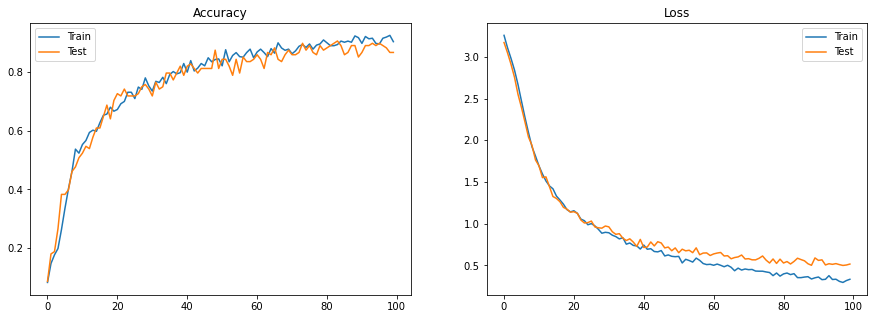

In [146]:
# Comparing performance metrics of the model
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(my_model.history['accuracy'],label='Train')
plt.plot(my_model.history['val_accuracy'],label='Test')
plt.title("Accuracy")
plt.legend()

plt.subplot(122)
plt.plot(my_model.history['loss'],label='Train')
plt.plot(my_model.history['val_loss'],label='Test')
plt.title("Loss")
plt.legend()
plt.show()

#### Making a single Prediction:

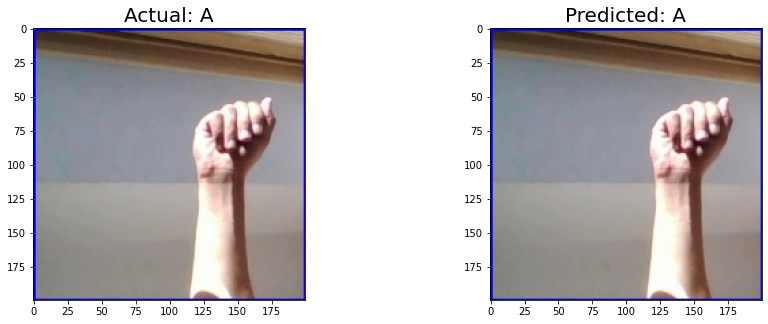

In [156]:
img1=cv2.imread("Alphabets_split/val/A/A626.jpg")
img1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
test_image = image.load_img('Alphabets_split/val/A/A626.jpg', target_size = (32, 32))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = transfer_model.predict(test_image/255.)
prediction=list(train_data.class_indices.keys())[np.argmax(result)]

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(img1)
plt.title("Actual: A",fontsize=20)

plt.subplot(122)
plt.imshow(img1)
plt.title("Predicted: {}".format(prediction),fontsize=20)
plt.show()

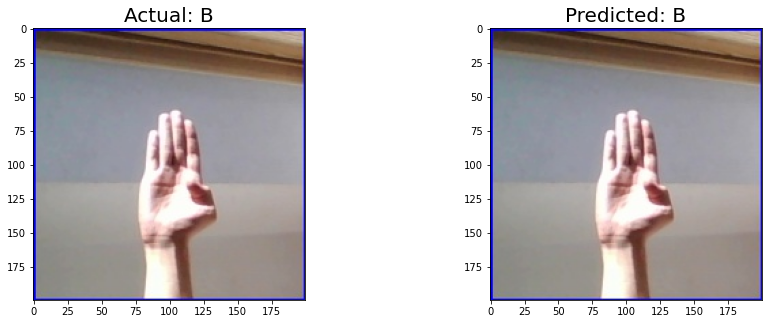

In [157]:
img1=cv2.imread("Alphabets_split/val/B/B691.jpg")
img1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
test_image = image.load_img('Alphabets_split/val/B/B691.jpg', target_size = (32, 32))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = transfer_model.predict(test_image/255.)
prediction=list(train_data.class_indices.keys())[np.argmax(result)]

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(img1)
plt.title("Actual: B",fontsize=20)

plt.subplot(122)
plt.imshow(img1)
plt.title("Predicted: {}".format(prediction),fontsize=20)
plt.show()

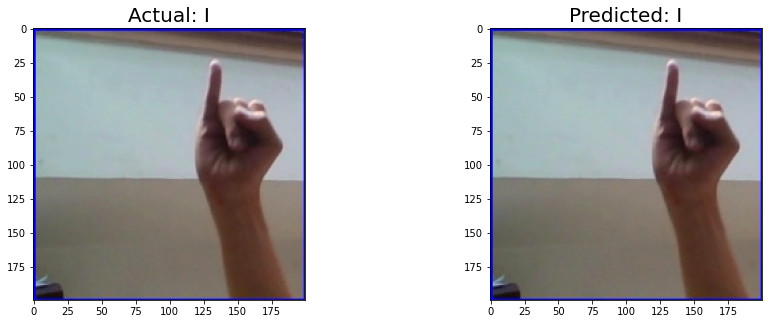

In [159]:
img1=cv2.imread("Alphabets_split/val/I/I578.jpg")
img1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
test_image = image.load_img('Alphabets_split/val/I/I578.jpg', target_size = (32, 32))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = transfer_model.predict(test_image/255.)
prediction=list(train_data.class_indices.keys())[np.argmax(result)]

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(img1)
plt.title("Actual: I",fontsize=20)

plt.subplot(122)
plt.imshow(img1)
plt.title("Predicted: {}".format(prediction),fontsize=20)
plt.show()

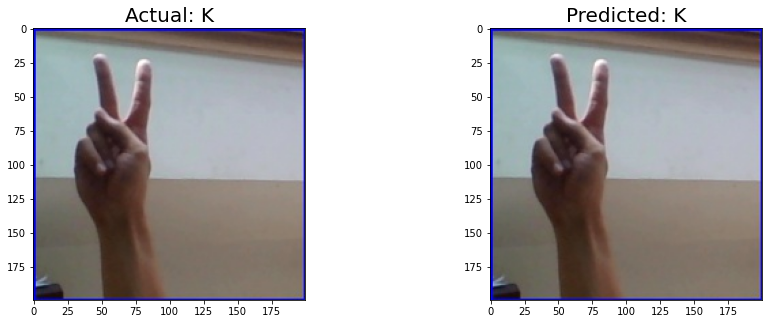

In [163]:
img1=cv2.imread("Alphabets_split/val/K/K530.jpg")
img1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
test_image = image.load_img('Alphabets_split/val/K/K530.jpg', target_size = (32, 32))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = transfer_model.predict(test_image/255.)
prediction=list(train_data.class_indices.keys())[np.argmax(result)]

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(img1)
plt.title("Actual: K",fontsize=20)

plt.subplot(122)
plt.imshow(img1)
plt.title("Predicted: {}".format(prediction),fontsize=20)
plt.show()

#### Xception:

In [32]:
train_datagen=ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_data=train_datagen.flow_from_directory("Alphabets_split/train",target_size=(128,128),class_mode='categorical',
    batch_size=8)

Found 518 images belonging to 26 classes.


In [33]:
val_datagen=ImageDataGenerator(rescale=1./255)

val_data=val_datagen.flow_from_directory("Alphabets_split/val",target_size=(128,128),class_mode='categorical',
    batch_size=8)

Found 130 images belonging to 26 classes.


In [34]:
model=Xception()

In [35]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [36]:
# Excluding the Convolution layers of the Xception model and setting the input shape same as that of target size during Data Augmentation
model=Xception(input_shape=(128,128,3),include_top=False)

In [37]:
# Train the weights of only the dense layers 
for layers in model.layers:
    if('dense' not in layers.name):
        layers.trainable=False
    if('dense' in layers.name):
        layers.trainable=True

In [38]:
#Adding the new dense layers to the Xception model
transfer_model=Sequential([model,
                          Flatten(),
                          Dense(32,activation='relu'),
                          Dense(26,activation='softmax')])
transfer_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1048608   
_________________________________________________________________
dense_7 (Dense)              (None, 26)                858       
Total params: 21,910,946
Trainable params: 1,049,466
Non-trainable params: 20,861,480
_________________________________________________________________


In [39]:
#Compiling the model using adam optimizer, loss as 'categorical_crossentropy' and metrics as accuracy
transfer_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [40]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
my_model=transfer_model.fit_generator(train_data,steps_per_epoch=518 //8,epochs=100,validation_data=val_data,validation_steps=130  //8)

Epoch 1/100
64/64 [==============================] - 39s 503ms/step - loss: 3.5099 - accuracy: 0.0471 - val_loss: 3.1519 - val_accuracy: 0.0859
Epoch 2/100
64/64 [==============================] - 30s 464ms/step - loss: 2.9839 - accuracy: 0.1039 - val_loss: 2.7387 - val_accuracy: 0.1562
Epoch 3/100
64/64 [==============================] - 30s 468ms/step - loss: 2.7271 - accuracy: 0.1549 - val_loss: 2.3928 - val_accuracy: 0.1953
Epoch 4/100
64/64 [==============================] - 30s 471ms/step - loss: 2.5289 - accuracy: 0.2059 - val_loss: 2.3051 - val_accuracy: 0.2734
Epoch 5/100
64/64 [==============================] - 30s 465ms/step - loss: 2.4195 - accuracy: 0.2549 - val_loss: 2.5433 - val_accuracy: 0.1953
Epoch 6/100
64/64 [==============================] - 30s 473ms/step - loss: 2.2954 - accuracy: 0.2725 - val_loss: 2.1267 - val_accuracy: 0.2969
Epoch 7/100
64/64 [==============================] - 29s 460ms/step - loss: 2.1008 - accuracy: 0.3078 - val_loss: 2.0800 - val_accuracy:

64/64 [==============================] - 28s 433ms/step - loss: 0.2616 - accuracy: 0.8961 - val_loss: 0.5975 - val_accuracy: 0.7891
Epoch 58/100
64/64 [==============================] - 27s 428ms/step - loss: 0.3047 - accuracy: 0.9000 - val_loss: 0.5739 - val_accuracy: 0.7969
Epoch 59/100
64/64 [==============================] - 28s 434ms/step - loss: 0.2795 - accuracy: 0.9118 - val_loss: 0.5205 - val_accuracy: 0.8516
Epoch 60/100
64/64 [==============================] - 28s 436ms/step - loss: 0.2992 - accuracy: 0.9118 - val_loss: 0.4742 - val_accuracy: 0.8750
Epoch 61/100
64/64 [==============================] - 28s 437ms/step - loss: 0.2713 - accuracy: 0.9078 - val_loss: 0.5861 - val_accuracy: 0.7969
Epoch 62/100
64/64 [==============================] - 28s 429ms/step - loss: 0.2879 - accuracy: 0.9020 - val_loss: 0.6786 - val_accuracy: 0.8047
Epoch 63/100
64/64 [==============================] - 28s 439ms/step - loss: 0.3772 - accuracy: 0.8706 - val_loss: 0.4141 - val_accuracy: 0.882

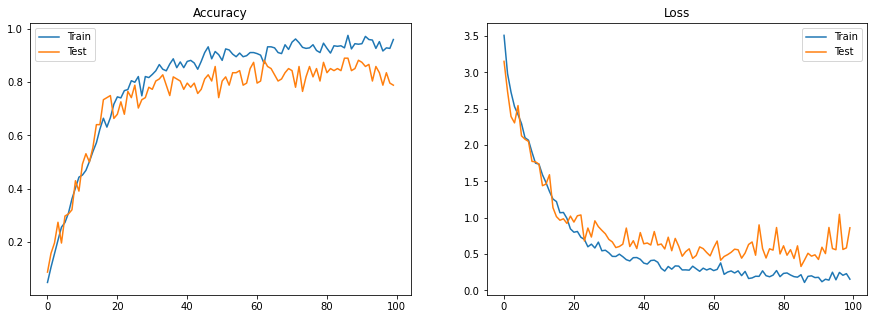

In [41]:
# Comparing performance metrics of the model
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(my_model.history['accuracy'],label='Train')
plt.plot(my_model.history['val_accuracy'],label='Test')
plt.title("Accuracy")
plt.legend()

plt.subplot(122)
plt.plot(my_model.history['loss'],label='Train')
plt.plot(my_model.history['val_loss'],label='Test')
plt.title("Loss")
plt.legend()
plt.show()

#### Make Single Predictions:

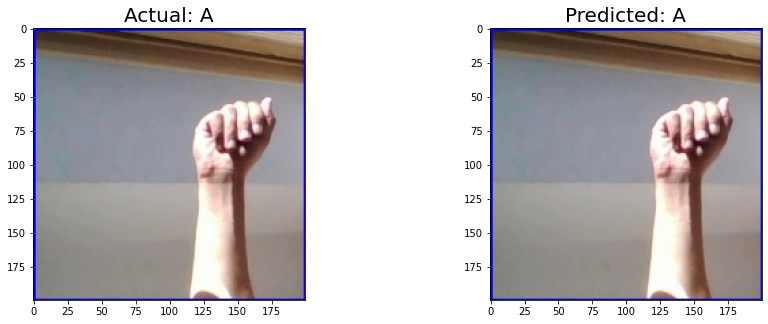

In [48]:
img1=cv2.imread("Alphabets_split/val/A/A626.jpg")
img1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
test_image = image.load_img('Alphabets_split/val/A/A626.jpg', target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = transfer_model.predict(test_image/255.)
prediction=list(train_data.class_indices.keys())[np.argmax(result)]

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(img1)
plt.title("Actual: A",fontsize=20)

plt.subplot(122)
plt.imshow(img1)
plt.title("Predicted: {}".format(prediction),fontsize=20)
plt.show()

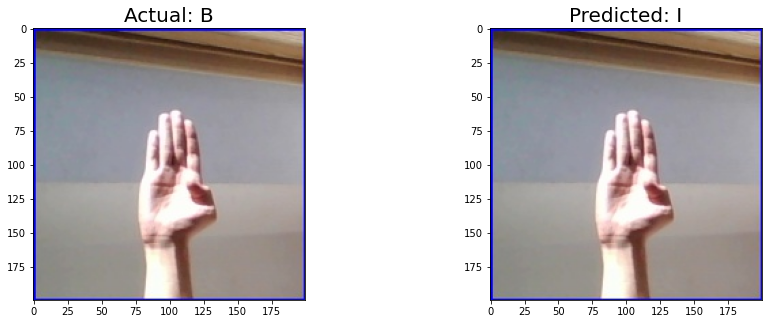

In [49]:
img1=cv2.imread("Alphabets_split/val/B/B691.jpg")
img1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
test_image = image.load_img('Alphabets_split/val/B/B691.jpg', target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = transfer_model.predict(test_image/255.)
prediction=list(train_data.class_indices.keys())[np.argmax(result)]

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(img1)
plt.title("Actual: B",fontsize=20)

plt.subplot(122)
plt.imshow(img1)
plt.title("Predicted: {}".format(prediction),fontsize=20)
plt.show()

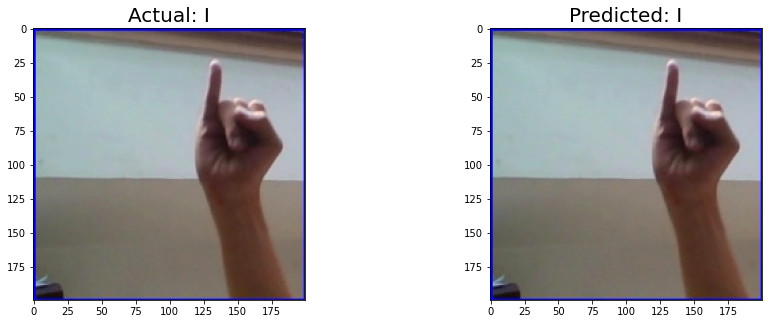

In [47]:
img1=cv2.imread("Alphabets_split/val/I/I578.jpg")
img1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
test_image = image.load_img('Alphabets_split/val/I/I578.jpg', target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = transfer_model.predict(test_image/255.)
prediction=list(train_data.class_indices.keys())[np.argmax(result)]

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(img1)
plt.title("Actual: I",fontsize=20)

plt.subplot(122)
plt.imshow(img1)
plt.title("Predicted: {}".format(prediction),fontsize=20)
plt.show()

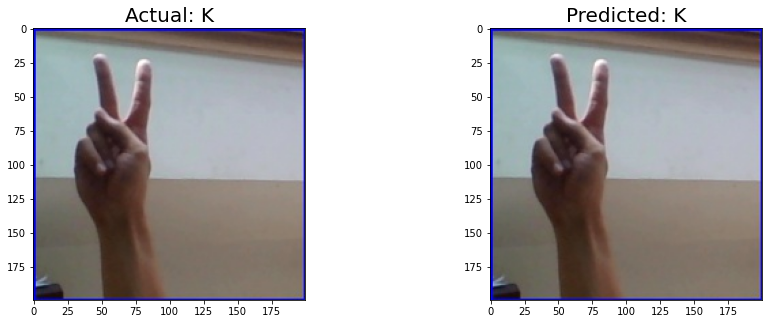

In [45]:
img1=cv2.imread("Alphabets_split/val/K/K530.jpg")
img1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
test_image = image.load_img('Alphabets_split/val/K/K530.jpg', target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = transfer_model.predict(test_image/255.)
prediction=list(train_data.class_indices.keys())[np.argmax(result)]

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(img1)
plt.title("Actual: K",fontsize=20)

plt.subplot(122)
plt.imshow(img1)
plt.title("Predicted: {}".format(prediction),fontsize=20)
plt.show()